In [148]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [123]:
# load dataset
height = 4
width = 4
depth = 24

all_hists = []
labels = []
zero_hists = []

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [1, 0, 0],
#     2: [0, 1, 0],
#     3: [0, 0, 1],
# }

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [1, 0, 0],
#     2: [0, 1, 0],
#     3: [0, 0, 1],
#     4: [1, 1, 0],
#     5: [1, 0, 1],
#     6: [0, 1, 1],
#     7: [1, 1, 1],
# }

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [1, 0, 0],
#     2: [0, 0, 0],
#     3: [0, 0, 0],
#     4: [1, 0, 0],
#     5: [1, 0, 0],
#     6: [0, 0, 0],
# }

# zone_to_label = {
#     0: [0, 0, 0],
#     1: [0, 0, 0],
#     2: [0, 1, 0],
#     3: [0, 0, 0],
#     4: [0, 1, 0],
#     5: [0, 0, 0],
#     6: [0, 1, 0],
# }

zone_to_label = {
    0: [0],
    1: [1],
    2: [1],
    3: [1],
    4: [1],
    5: [1],
    6: [1],
}

# for i in range(7):
#     hists = np.load(f'datasets/window-board-2/histograms_{i}.npy')
#     all_hists.append(hists)

#     if i == 0:
#         zero_hists.append(hists)
    
#     # labels += [i] * len(hists)

#     # is_nonzero = (i != 0)
#     # labels += [is_nonzero] * len(hists)

#     labels += [zone_to_label[i]] * len(hists)

In [124]:

# fine tuning setup
for i in range(4):
    hists = np.load(f'datasets/display-box-1/histograms_{i}.npy')
    all_hists.append(hists)

    if i == 0:
        zero_hists.append(hists)
    
    # labels += [i] * len(hists)

    # is_nonzero = (i != 0)
    # labels += [is_nonzero] * len(hists)

    labels += [zone_to_label[i]] * len(hists)


In [125]:
zero_hists = np.concatenate(zero_hists, axis=0)
all_hists = np.concatenate(all_hists, axis=0)
labels = np.array(labels)

all_hists = all_hists.reshape(-1, height, width, depth)
# move depth to the front
all_hists = np.moveaxis(all_hists, -1, 1)

zero_hists = zero_hists.reshape(-1, height, width, depth)
zero_hists = np.moveaxis(zero_hists, -1, 1)

# crop first bounce bins (first bounce in first 2 bins)
all_hists = all_hists[:, 2:, :, :]
zero_hists = zero_hists[:, 2:, :, :]

# generate more data by adding gaussian noise

all_hists = np.repeat(all_hists, 10, axis=0)
labels = np.repeat(labels, 10, axis=0)

# add noise
# std = 3 is good for general training?
all_hists += np.random.normal(0, 1, all_hists.shape)



all_hists = torch.tensor(all_hists, dtype=torch.float32)
zero_hists = torch.tensor(zero_hists, dtype=torch.float32)


In [126]:
# pick 10 random zero hists to act as the zero mean
num_samples_to_mean = 20

random_zero_mean = torch.empty((all_hists.shape[0], all_hists.shape[1], height, width))

for i in range(all_hists.shape[0]):
    indices = torch.randint(0, zero_hists.shape[0], (num_samples_to_mean,))
    random_zero_mean[i] = zero_hists[indices].mean(dim=0)

In [127]:
all_hists_rel = all_hists - random_zero_mean

In [ ]:
# mean all pixels
# all_hists_rel = all_hists_rel.mean(dim=(2, 3), keepdim=True)

In [114]:
# zero_mean = np.mean(zero_hists, axis=0)

# # lower bound at 0
# # all_hists = np.maximum(all_hists, 0)
# # zero_mean = np.maximum(zero_mean, 0)
# all_hists_rel = all_hists - zero_mean

In [1026]:
# value-based normalization
# data is of shape (n x depth x height x width): (n, 24, 4, 4)
# apply 2d gaussian over heigh x width

# kernel = [0.5, 1, 0.5]

# blurred = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=0.5, mode='constant'), 2, all_hists_rel)
# blurred = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=0.5, mode='constant'), 3, blurred)

# # 1d gaussian over depth
blurred = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=0.5, mode='constant'), 1, blurred)

all_hists_rel = blurred

# sharpened = all_hists_rel - blurred
# all_hists_rel = sharpened

In [1087]:
# normalize values

In [4]:
# plot histogram of values of all_hists on log scale in matplotlib
temp = all_hists_rel[labels==2].flatten()
fig, ax = plt.subplots()
# ax.hist(temp[(temp > 10) | (temp < -10)], bins=50)
ax.hist(temp, bins=50)
plt.show()


IndexError: boolean index did not match indexed array along dimension 1; dimension is 24 but corresponding boolean dimension is 3

In [4]:
print(f"nonnegative count: {np.sum(zero_mean >= 0)}")
print(f"negative count: {np.sum(zero_mean < 0)}")
print(f"total count: {zero_mean.size}")

nonnegative count: 113
negative count: 271
total count: 384


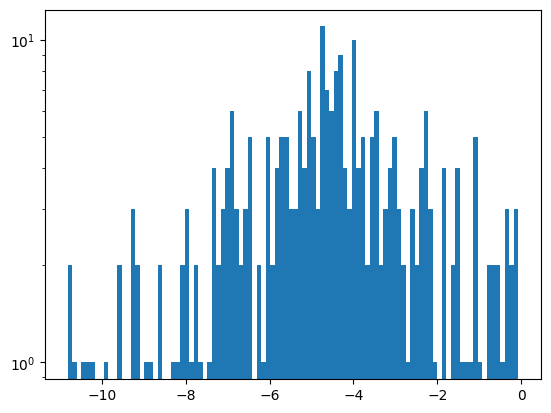

In [5]:
# plot histogram of all negative samples in all_hists

fig, ax = plt.subplots()
ax.hist(zero_mean[zero_mean < 0].flatten(), bins=100, log=True)
plt.show()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 24 but corresponding boolean dimension is 3

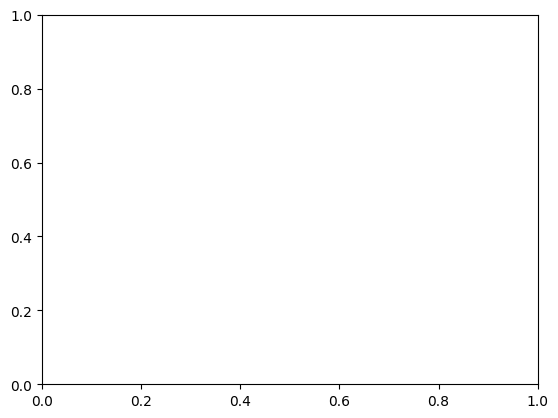

In [6]:
fig, ax = plt.subplots()
ax.hist(all_hists_rel[labels == 0].flatten(), bins=100, log=True)
plt.show()

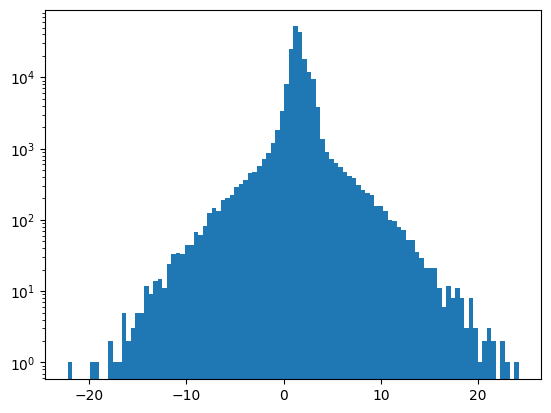

In [ ]:
fig, ax = plt.subplots()
ax.hist(all_hists_rel[labels == 9].flatten(), bins=100, log=True)
plt.show()

In [128]:
print(f'shape of all_hists: {all_hists.shape}')
print(f'shape of labels: {labels.shape}')
print(f'shape of zero_mean: {all_hists_rel.shape}')
print(f'shape of all_hists_rel: {all_hists_rel.shape}')

shape of all_hists: torch.Size([40000, 22, 4, 4])
shape of labels: (40000, 1)
shape of zero_mean: torch.Size([40000, 22, 4, 4])
shape of all_hists_rel: torch.Size([40000, 22, 4, 4])


In [129]:
# Convert numpy arrays to PyTorch tensors
# all_hists_tensor = torch.tensor(all_hists, dtype=torch.float32)
# all_hists_tensor = torch.tensor(all_hists_rel, dtype=torch.float32)
all_hists_tensor = all_hists_rel
# labels_tensor = torch.tensor(labels, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# all_hists_tensor = torch.sign(all_hists_tensor) * torch.log1p(torch.abs(all_hists_tensor))


# epsilon = 0.1  # Smoothing factor
# labels_tensor = (1 - epsilon) * labels_tensor + epsilon * 0.5  # Smooth towards uniform distribution

# Create a TensorDataset
dataset = TensorDataset(all_hists_tensor, labels_tensor)

# Define the sizes for training, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [130]:
for batch_x, batch_y in train_loader:
    print(f'batch_x shape: {batch_x.shape}')
    print(f'batch_y shape: {batch_y.shape}')
    break

batch_x shape: torch.Size([32, 22, 4, 4])
batch_y shape: torch.Size([32, 1])


In [131]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [330]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)  # Assuming 10 classes for the labels
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(f'x shape at start: {x.shape}')
        x = self.relu(self.conv1(x))
        # print(f'x shape after conv1: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool1: {x.shape}')
        x = self.relu(self.conv2(x))
        # print(f'x shape after conv2: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
class BigCNN(nn.Module):
    def __init__(self):
        super(BigCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes for the labels
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(f'x shape at start: {x.shape}')
        x = self.relu(self.conv1(x))
        # print(f'x shape after conv1: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool1: {x.shape}')
        x = self.relu(self.conv2(x))
        # print(f'x shape after conv2: {x.shape}')
        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        x = nn.Dropout(0.5)(x)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
# model = BigCNN().to(device)
# print(model)

BigCNN(
  (conv1): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [132]:
class CounterCNN(nn.Module):
    def __init__(self):
        super(CounterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth-2, out_channels=32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)  # Assuming 10 classes for the labels
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # print(f'x shape at start: {x.shape}')
        x = self.relu(self.conv1(x))
        # print(f'x shape after conv1: {x.shape}')
        x = self.batchnorm1(x)
        # x = self.pool(x)
        # print(f'x shape after pool1: {x.shape}')
        x = self.relu(self.conv2(x))
        # print(f'x shape after conv2: {x.shape}')
        x = self.batchnorm2(x)
        # # x = self.pool(x)
        # # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CounterCNN().to(device)
print(model)

CounterCNN(
  (conv1): Conv2d(22, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [133]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(initialize_weights)

CounterCNN(
  (conv1): Conv2d(22, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [134]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=10.0)

In [135]:
def train(dataloader, model, loss_fn, optimizer, counter=False, clipping=False, debug=False):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # print(f'X shape: {X.shape}, y shape: {y.shape}')
        # Compute prediction error
        pred = model(X)
        # if counter:
            # y = y.unsqueeze(1)
        # print(f'pred shape: {pred.shape}, y shape: {y.shape}')
        loss = loss_fn(pred, y)
        # print(f'loss: {loss.item()}')
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        if clipping:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed
        
        if debug:
            # Inspect gradients for each layer
            for name, param in model.named_parameters():
                if param.grad is not None:  # Only check if gradient is computed
                    print(f"Layer: {name} | Gradient mean: {param.grad.abs().mean().item()} | Gradient max: {param.grad.abs().max().item()}")
                else:
                    print(f"Layer: {name} has no gradient.")

        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= len(dataloader)
    return train_loss

In [136]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [137]:
def test_counter(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # y = y.unsqueeze_(1)
            # print(X.shape)
            # print(y.shape)
            test_loss += loss_fn(pred, y).item()
            final_pred = torch.round(torch.clamp(pred, min=0, max=1))
            
            # print(final_pred.shape)
            # print("true")
            # print(y)
            # print("pred")
            # print(final_pred)
            # print("diff")
            # print(final_pred - y)
            exact_match = torch.all(final_pred == torch.round(y), dim=1)
            correct += torch.sum(exact_match).item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [138]:
def train_early_stopping(train_loader, val_loader, model, loss_fn, optimizer, 
    epochs=50, early_stopping=True, patience=5, threshold=0.15, counter=False, clipping=False, debug=False):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, counter=counter, clipping=clipping, debug=debug)
        if counter:
            val_loss, correct = test_counter(val_loader, model, loss_fn)
        else:
            val_loss, correct = test(val_loader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                patience_counter = 0
            else:
                if val_loss / best_val_loss > 1 + threshold:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {t+1}")
                        break
        # print(f'patience_counter: {patience_counter}')
    return best_model, train_losses, val_losses

Epoch 1
-------------------------------
loss: 0.917006  [   32/20000]
loss: 0.515045  [ 3232/20000]
loss: 0.678481  [ 6432/20000]
loss: 0.672900  [ 9632/20000]
loss: 0.523096  [12832/20000]
loss: 0.552139  [16032/20000]
loss: 0.612393  [19232/20000]
Test Error: 
 Accuracy: 75.3%, Avg loss: 0.558388 

Epoch 2
-------------------------------
loss: 0.545171  [   32/20000]
loss: 0.623195  [ 3232/20000]
loss: 0.580367  [ 6432/20000]
loss: 0.560406  [ 9632/20000]
loss: 0.657319  [12832/20000]
loss: 0.596396  [16032/20000]
loss: 0.459972  [19232/20000]
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.542590 

Epoch 3
-------------------------------
loss: 0.372544  [   32/20000]
loss: 0.484048  [ 3232/20000]
loss: 0.559015  [ 6432/20000]
loss: 0.493665  [ 9632/20000]
loss: 0.419613  [12832/20000]
loss: 0.656563  [16032/20000]
loss: 0.574146  [19232/20000]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.539524 

Epoch 4
-------------------------------
loss: 0.505703  [   32/20000]
loss: 0.505505  [ 3232/2

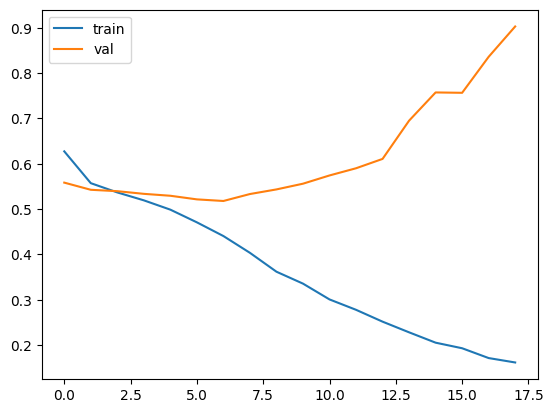

In [139]:
best_model, train_losses, val_losses = train_early_stopping(
    train_loader, val_loader, model, loss_fn, optimizer, epochs=500, early_stopping=True,
    threshold=0.2,
    counter=True, clipping=True)

# plot training and validation losses
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


model = best_model

In [140]:
model_save_path = 'models/display-box-5-binary.pth'

In [141]:
torch.save(model.state_dict(), model_save_path)

In [142]:
model = CounterCNN().to(device)
model.load_state_dict(torch.load(model_save_path))

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_19490/2522857457.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

<All keys matched successfully>

In [143]:
# Out of sample test
model.eval()
# test(test_loader, model, loss_fn)
test_counter(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.948537 



(0.9485368596764799, 0.73)

In [144]:
for i in range(20):
    # Get a single example from the test dataset
    example_data, example_label = test_dataset[i]

    # Move the example data to the appropriate device
    example_data = example_data.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        example_data = example_data.to(device)
        output = model(example_data)

    # Get the predicted class
    predicted_class = output.argmax(dim=1).item()

    # Print the predicted class and the actual label
    print(f'Predicted class: {predicted_class}, Actual label: {example_label}')

Predicted class: 0, Actual label: tensor([0.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([0.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([0.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([0.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([0.])
Predicted class: 0, Actual label: tensor([1.])
Predicted class: 0, Actual label: tensor([1.])


In [145]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        output = model(X)
        # predicted_classes = output.argmax(dim=1)
        # predictions.extend(predicted_classes.cpu().numpy())
        predicted_zones = torch.round(torch.clamp(output, min=0, max=1))
        predictions.extend(predicted_zones.cpu().numpy())

# Convert predictions to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in test_dataset])

[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [116]:
# FULL DATASET
# Create a DataLoader for the entire dataset
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Initialize a list to store the predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in full_loader:
        X = X.to(device)
        output = model(X)
        predicted_classes = output.argmax(dim=1)
        predictions.extend(predicted_classes.cpu().numpy())

# Convert outputs to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in dataset])

[1 0 1 ... 2 2 2]


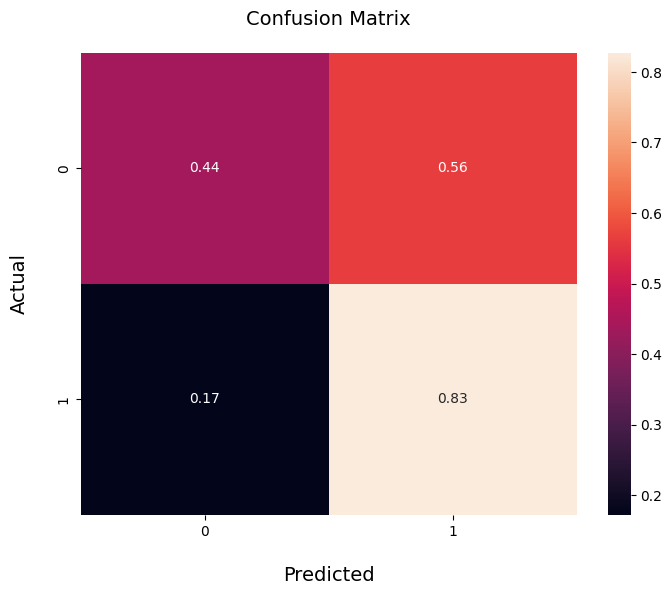

In [146]:
y_test = np.array([y[0] for _, y in test_dataset]).astype(int)
y_preds = np.array([p[0] for p in predictions]).astype(int)
conf_matrix = confusion_matrix(y_test, y_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', )
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# tick_labels = [0, 1, 2, 3, 4, 5, 6]
# tick_labels = [0, 1, 2]
tick_labels = [0, 1]
ax.xaxis.set_ticklabels(tick_labels)
 
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(tick_labels)
 
# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
 
plt.show()

In [147]:
y_test = np.array([y for _, y in test_dataset]).astype(int)
y_preds = np.array([p for p in predictions]).astype(int)

# plot accuracy of each zone
correct = (y_test == y_preds)
zone_correct = np.sum(correct, axis=0)
zone_total = np.sum(y_test == y_test, axis=0)

zone_accuracy = zone_correct / zone_total
print(zone_accuracy)

category_y_test = y_test.dot(2**np.array([1, 2, 4]))
category_y_preds = y_preds.dot(2**np.array([1, 2, 4]))

conf_matrix = confusion_matrix(category_y_test, category_y_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', )
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# tick_labels = ["000", "001", "010", "011", "100", "101", "110"]
tick_labels = ["0", "1"]
ax.xaxis.set_ticklabels(tick_labels)
 
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(tick_labels)
 
# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
 
plt.show()

[0.73]


ValueError: shapes (10000,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)